In [10]:
from huggingface_hub import list_repo_files

files = list_repo_files("manueltonneau/indonesian-hate-speech-superset", repo_type="dataset")
print(files)


['.gitattributes', 'README.md', 'in_hf.csv']


In [11]:
from huggingface_hub import hf_hub_download
import pandas as pd

file_path = hf_hub_download(
    repo_id="manueltonneau/indonesian-hate-speech-superset",
    filename="in_hf.csv",
    repo_type="dataset"
)

df = pd.read_csv(file_path)
print(df.head())


in_hf.csv:   0%|          | 0.00/2.01M [00:00<?, ?B/s]

                                                text  labels     source  \
0  @USER.wood17 knp lo gak berani bersumpah dan b...       1  Instagram   
1  haha, somad somad. Muka dekil otak 0% , kok ya...       1  Instagram   
2  hahaha, kaum sableng 212 kl berita begini mrk ...       1  Instagram   
3  hahaha, makin stress aja  ni umat sableng, dlu...       1  Instagram   
4       HIDUP PSI = partai SAMPAH indonesia..... ...       1  Instagram   

        dataset  nb_annotators  
0  ID_instagram              3  
1  ID_instagram              3  
2  ID_instagram              3  
3  ID_instagram              3  
4  ID_instagram              3  


In [12]:
import pandas as pd
import re

# Assuming you have loaded the CSV into a dataframe 'df'
# For example: df = pd.read_csv('in_hf.csv')

# Select only the necessary columns
df = df[['text', 'labels']]

# Basic text cleaning function
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'@\w+', '', text)  # remove user mentions like @USER
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-z0-9\s]', '', text)  # remove special characters except space and alphanumeric
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# Check sample output
print(df[['clean_text', 'labels']].head())


                                          clean_text  labels
0  wood17 knp lo gak berani bersumpah dan bertaru...       1
1  haha somad somad muka dekil otak 0 kok ya g ma...       1
2  hahaha kaum sableng 212 kl berita begini mrk b...       1
3  hahaha makin stress aja ni umat sableng dlu ra...       1
4                  hidup psi partai sampah indonesia       1


In [13]:
print(df['labels'].value_counts())


labels
0    8256
1    6050
Name: count, dtype: int64


In [14]:
from transformers import BertTokenizer

# Initialize multilingual BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Simple function to tokenize text and get input ids & attention masks
def tokenize_data(texts, max_len=128):
    return tokenizer(
        texts.tolist(),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [26]:
from torch.utils.data import Dataset
import torch

class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),  # [max_len]
            'attention_mask': encoding['attention_mask'].squeeze(),  # [max_len]
            'labels': torch.tensor(label, dtype=torch.long)  # ✅ must be 'labels'
        }


In [27]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Corrected column names based on your DataFrame
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['clean_text'], df['labels'], test_size=0.2, random_state=42, stratify=df['labels']
)

# Create datasets
train_dataset = HateSpeechDataset(train_texts.values, train_labels.values, tokenizer)
val_dataset = HateSpeechDataset(val_texts.values, val_labels.values, tokenizer)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [29]:
import torch.nn as nn
from transformers import BertModel

class MBertLSTM(nn.Module):
    def __init__(self, bert_model_name='bert-base-multilingual-cased', lstm_hidden_dim=128, lstm_layers=2, dropout=0.3):
        super(MBertLSTM, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.lstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(lstm_hidden_dim * 2, 2)  # binary classification (2 classes)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_output.last_hidden_state  # (batch_size, seq_len, hidden_size)

        lstm_output, _ = self.lstm(sequence_output)  # (batch_size, seq_len, hidden_size*2)

        # Use output of last LSTM timestep
        lstm_last_output = lstm_output[:, -1, :]

        out = self.dropout(lstm_last_output)
        logits = self.classifier(out)
        return logits


In [30]:
import torch

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss(weight=class_weights)


In [31]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MBertLSTM().to(device)

optimizer = optim.AdamW(model.parameters(), lr=2e-5)


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0
    total = 0

    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        preds = torch.argmax(outputs, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total += labels.size(0)

    return correct_predictions / total, sum(losses) / len(losses)


In [33]:
def eval_model(model, data_loader, criterion, device):
    model.eval()
    losses = []

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            losses.append(loss.item())

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    return accuracy, np.mean(losses), precision, recall, f1


In [34]:
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}")

    val_acc, val_loss, val_prec, val_rec, val_f1 = eval_model(model, val_loader, criterion, device)
    print(f"Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}, Val precision: {val_prec:.4f}, Val recall: {val_rec:.4f}, Val F1: {val_f1:.4f}")


Epoch 1/5


100%|██████████| 716/716 [04:38<00:00,  2.57it/s]


Train loss: 0.5354, Train accuracy: 0.7241


100%|██████████| 179/179 [00:20<00:00,  8.63it/s]


Val loss: 0.4374, Val accuracy: 0.7739, Val precision: 0.6661, Val recall: 0.9331, Val F1: 0.7773
Epoch 2/5


100%|██████████| 716/716 [04:36<00:00,  2.59it/s]


Train loss: 0.3556, Train accuracy: 0.8485


100%|██████████| 179/179 [00:20<00:00,  8.71it/s]


Val loss: 0.3898, Val accuracy: 0.8337, Val precision: 0.7528, Val recall: 0.9033, Val F1: 0.8212
Epoch 3/5


100%|██████████| 716/716 [04:36<00:00,  2.59it/s]


Train loss: 0.2472, Train accuracy: 0.9054


100%|██████████| 179/179 [00:20<00:00,  8.65it/s]


Val loss: 0.4246, Val accuracy: 0.8431, Val precision: 0.8184, Val recall: 0.8083, Val F1: 0.8133
Epoch 4/5


100%|██████████| 716/716 [04:36<00:00,  2.59it/s]


Train loss: 0.1761, Train accuracy: 0.9358


100%|██████████| 179/179 [00:20<00:00,  8.68it/s]


Val loss: 0.4711, Val accuracy: 0.8127, Val precision: 0.7169, Val recall: 0.9207, Val F1: 0.8061
Epoch 5/5


100%|██████████| 716/716 [04:36<00:00,  2.59it/s]


Train loss: 0.1183, Train accuracy: 0.9589


100%|██████████| 179/179 [00:20<00:00,  8.64it/s]

Val loss: 0.4310, Val accuracy: 0.8361, Val precision: 0.7633, Val recall: 0.8876, Val F1: 0.8208


In [35]:
epochs = 10  # You can increase if early stopping is active
best_val_acc = 0.0
patience = 2
counter = 0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    train_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}")

    val_acc, val_loss, val_prec, val_rec, val_f1 = eval_model(model, val_loader, criterion, device)
    print(f"Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}, Val precision: {val_prec:.4f}, Val recall: {val_rec:.4f}, Val F1: {val_f1:.4f}")

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")  # Save best model
        print("✅ Validation accuracy improved. Saving model.")
    else:
        counter += 1
        print(f"⏳ No improvement. Early stop patience: {counter}/{patience}")
        if counter >= patience:
            print("⛔ Early stopping triggered.")
            break



Epoch 1/10


100%|██████████| 716/716 [04:37<00:00,  2.58it/s]


Train loss: 0.0974, Train accuracy: 0.9676


100%|██████████| 179/179 [00:20<00:00,  8.59it/s]


Val loss: 0.4833, Val accuracy: 0.8445, Val precision: 0.7954, Val recall: 0.8512, Val F1: 0.8224
✅ Validation accuracy improved. Saving model.

Epoch 2/10


100%|██████████| 716/716 [04:37<00:00,  2.58it/s]


Train loss: 0.0756, Train accuracy: 0.9761


100%|██████████| 179/179 [00:20<00:00,  8.58it/s]


Val loss: 0.5673, Val accuracy: 0.8445, Val precision: 0.7874, Val recall: 0.8661, Val F1: 0.8249
⏳ No improvement. Early stop patience: 1/2

Epoch 3/10


100%|██████████| 716/716 [04:37<00:00,  2.58it/s]


Train loss: 0.0564, Train accuracy: 0.9829


100%|██████████| 179/179 [00:20<00:00,  8.56it/s]


Val loss: 0.5914, Val accuracy: 0.8459, Val precision: 0.8069, Val recall: 0.8355, Val F1: 0.8210
✅ Validation accuracy improved. Saving model.

Epoch 4/10


100%|██████████| 716/716 [04:37<00:00,  2.58it/s]


Train loss: 0.0536, Train accuracy: 0.9837


100%|██████████| 179/179 [00:20<00:00,  8.64it/s]


Val loss: 0.5982, Val accuracy: 0.8452, Val precision: 0.8269, Val recall: 0.8017, Val F1: 0.8141
⏳ No improvement. Early stop patience: 1/2

Epoch 5/10


100%|██████████| 716/716 [04:36<00:00,  2.59it/s]


Train loss: 0.0512, Train accuracy: 0.9839


100%|██████████| 179/179 [00:20<00:00,  8.59it/s]

Val loss: 0.6900, Val accuracy: 0.8389, Val precision: 0.7883, Val recall: 0.8463, Val F1: 0.8163
⏳ No improvement. Early stop patience: 2/2
⛔ Early stopping triggered.


In [37]:
torch.save(model.state_dict(), 'best_model_state.bin')


In [38]:
import os

if os.path.exists('best_model_state.bin'):
    print("✅ Model file saved successfully.")
else:
    print("❌ Model file not found.")


✅ Model file saved successfully.


In [39]:
model.load_state_dict(torch.load('best_model_state.bin'))
model.to(device)
model.eval()


MBertLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [46]:
all_preds = []
all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # logits directly
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # only for binary classification
        all_labels.extend(labels.cpu().numpy())


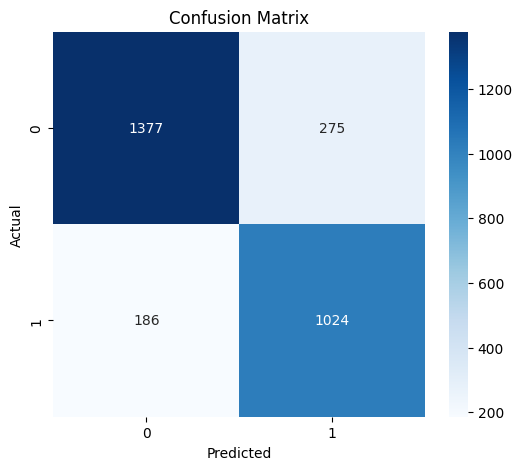

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86      1652
           1       0.79      0.85      0.82      1210

    accuracy                           0.84      2862
   macro avg       0.83      0.84      0.84      2862
weighted avg       0.84      0.84      0.84      2862



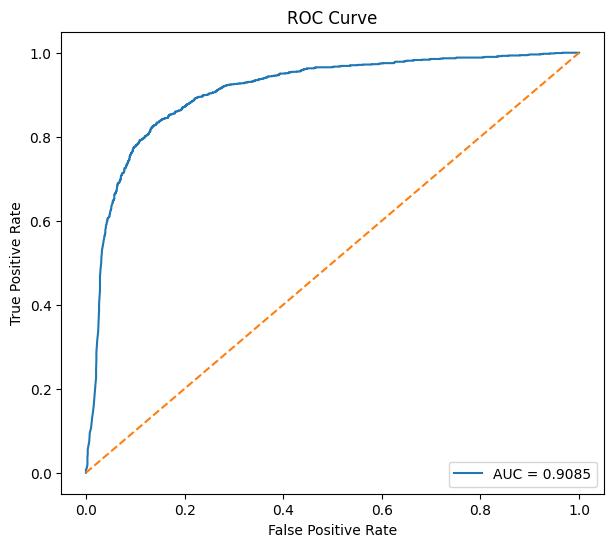

In [47]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 2. Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# 3. ROC Curve and AUC
auc = roc_auc_score(all_labels, all_probs)
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
